# estdel

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import hera_cal
import pyuvdata

import estdel

## Estimating the cable delay for a redundant visibility ratio

 Load data

In [3]:
uvd = pyuvdata.UVData()

# data
miriad_path = '../zen_data/zen.2458098.58037.xx.HH.uv'
uvd.read_miriad(miriad_path)

# get the redundant baselines for that data
aa = hera_cal.utils.get_aa_from_uv(uvd)
info = hera_cal.omni.aa_to_info(aa)
red_bls = np.array(info.get_reds())

From one redundant baseline select two unique separations

In [19]:
red_bl = red_bls[np.random.randint(len(red_bls))]
two_seps = [random.sample(red_bl, 2)][0]  
two_seps

[(25, 123), (24, 122)]

Get data for those separations 

In [20]:
data = {}
for sep in two_seps:
    data[sep] = uvd.get_data(sep)

Construct visibility ratio

In [21]:
waterfall = data[two_seps[0]] * data[two_seps[1]].conjugate()

Take a look

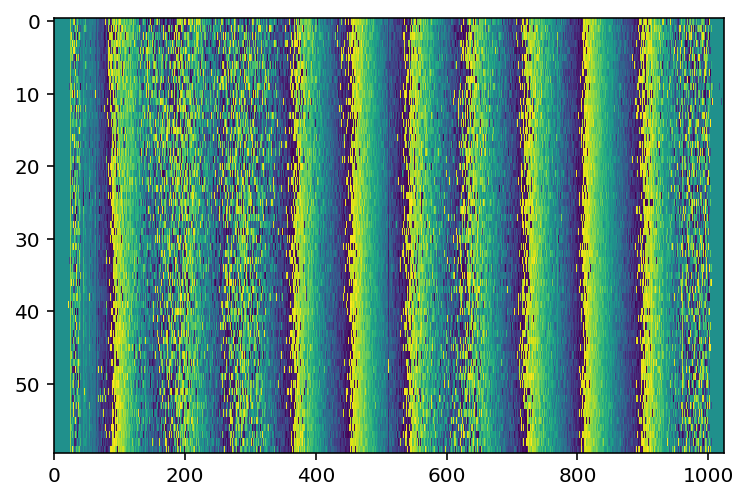

In [22]:
plt.imshow(np.angle(waterfall), aspect = 'auto');

## Predict cable delays for data

In [23]:
predictor = estdel.Delay(waterfall)

In [24]:
predictions = predictor.predict()

`predictor.raw_predictions` are in range -0.0400, 0.0400, unitless, based on 1024 unitless frequency channels.

`predictor.predictions` are converted to nanoseconds based on 100MHz spread over 1024 channels

`predictor.predict(conversion_fn=None)` gives raw_predictions

One visibility should have one overall total cable delay.

In [25]:
print('Mean cable delay for this waterfall = {}ns'.format(np.mean(predictions)))

Mean cable delay for this waterfall = 113.60415ns


In [26]:
print('Standard deviation of cable delay for this waterfall = {}ns'.format(np.std(predictions)))

Standard deviation of cable delay for this waterfall = 1.40297777156ns


Plot the angle of each row of the waterfall side by side with the prediction

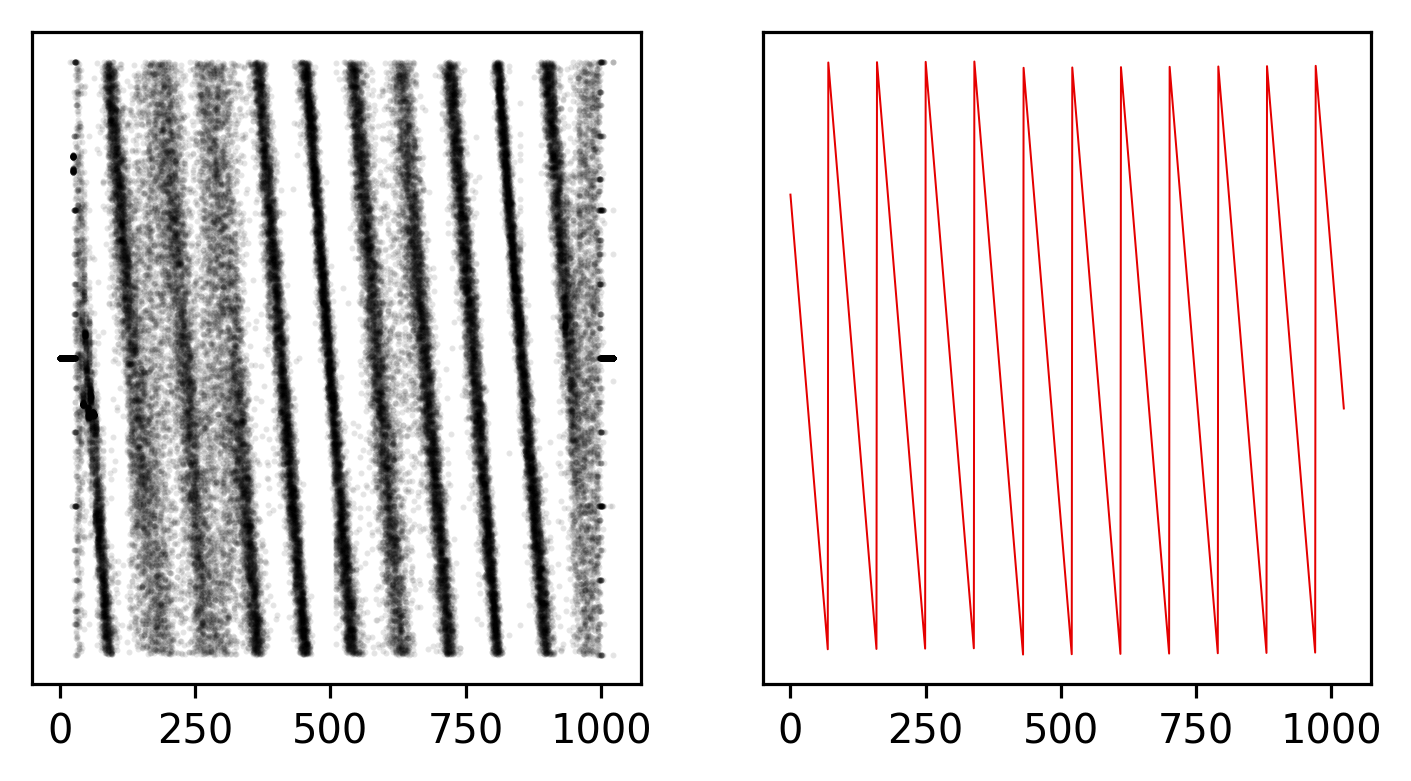

In [27]:


fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=144)
for row in waterfall:
    axes[0].plot(
        np.angle(row), ls="none", marker=".", markersize=1, alpha=0.1, color="black"
    )

axes[1].plot(
    np.angle(
        np.exp(
            -2j
            * np.pi
            * (
                np.linspace(0.100, 0.200, 1024) * np.mean(predictions)
                + np.random.uniform()
            )
        )
    ),
    color="#E50000",
    lw=0.5,
)
for ax in axes:
    ax.set_yticks([])
plt.show()